# Phase Diagram calculations

- Given a set composition we can use `ptt` to assess the phase stability at different P-T conditions to construct a phase diagram.
- These calculations can be performed with either the MELTS or Holland & Powell family of thermodynamic models (through MAGEMin).
- Also use outputs to assess the variability in key geochemical parameters across P-T space (e.g., phase proportions or chemistry).

**Before any calculations can be run** users need to download the alphaMELTS for MATLAB files and/or install the MAGEMinCalc and juliacall packages. Please see the installation guide on ReadTheDocs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# If the alphaMELTS for Python files have not been added to your Python path (see installation guide) then use the two lines below to add
# the location of the alphaMELTS files here.
# import sys
# sys.path.append(r'C:\Users\penny\Box\Berkeley_new\MELTS_Installation\alphamelts_py\alphamelts-py-2.3.1-win64')


import petthermotools as ptt 

ptt.__version__

%matplotlib widget

alphaMELTS for Python files successfully located.


In [2]:
ptt.GenFuncs._ensure_julia_ready()

Julia environment detected.


As in all examples we will import the key packages including `ptt`. The only difference here is that we will also use `%matplotlib widget` to make the phase diagram plots interactive (more explanation later).

The cell below can be used for users running MacOS to suppress the outputs (you need to run it twice). I'm still trying to find a better way to deadl with this - if you have suggestions please let me know.

In [4]:
# Should be used to suppress outputs on MacOS - run twice - if on windows, wont do anything. 
import platform
if platform.system() == "Darwin":
    import sys
    import os
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

#### Calculations using MELTS

For simplicity we're going to use one of the 'in-built' compostiions from `ptt`, specifically the composition of the KLB-1 peridotite. For the purposes of the MELTS calculations below we will set the K2O content to 0.0 wt% (otherwise the system will always stabilize melt as it doesn't have an alternative option for where to place the K2O). The calculations here will be performed using the "pMELTS" thermodynamic model as it is the most appropriate for mantle conditions and compositions.

In [5]:
KLB1 = ptt.Compositions['KLB-1']
KLB1['K2O_Liq'] = 0.0


We can now run `ptt.phaseDiagram_calc` which takes an array of pressure and temperature conditions and evaluates the equilibrium assemblage at each combination of values. The import parameters to tweak are:
1) The `i_max` parameters determines the maximum number of iterations that the code will loop through (a new loop is started if one calculation fails) unless every point either has a solution or hits a failure point. Smaller i_max, more likely to have holes in the phase diagram (as if one calculation kills a subprocess with 7 more calculations to run, you will get 7 holes until you have i_max>1). 15 is generally a good value to use. 
2) The `refine = 2` parameter helps refine the phase boundaries. Consider that your 25 pressure and temperature points creates the grid shown below. Initially, the phase boundary between olivine and liquid is put at the midpoint between the solved values. 
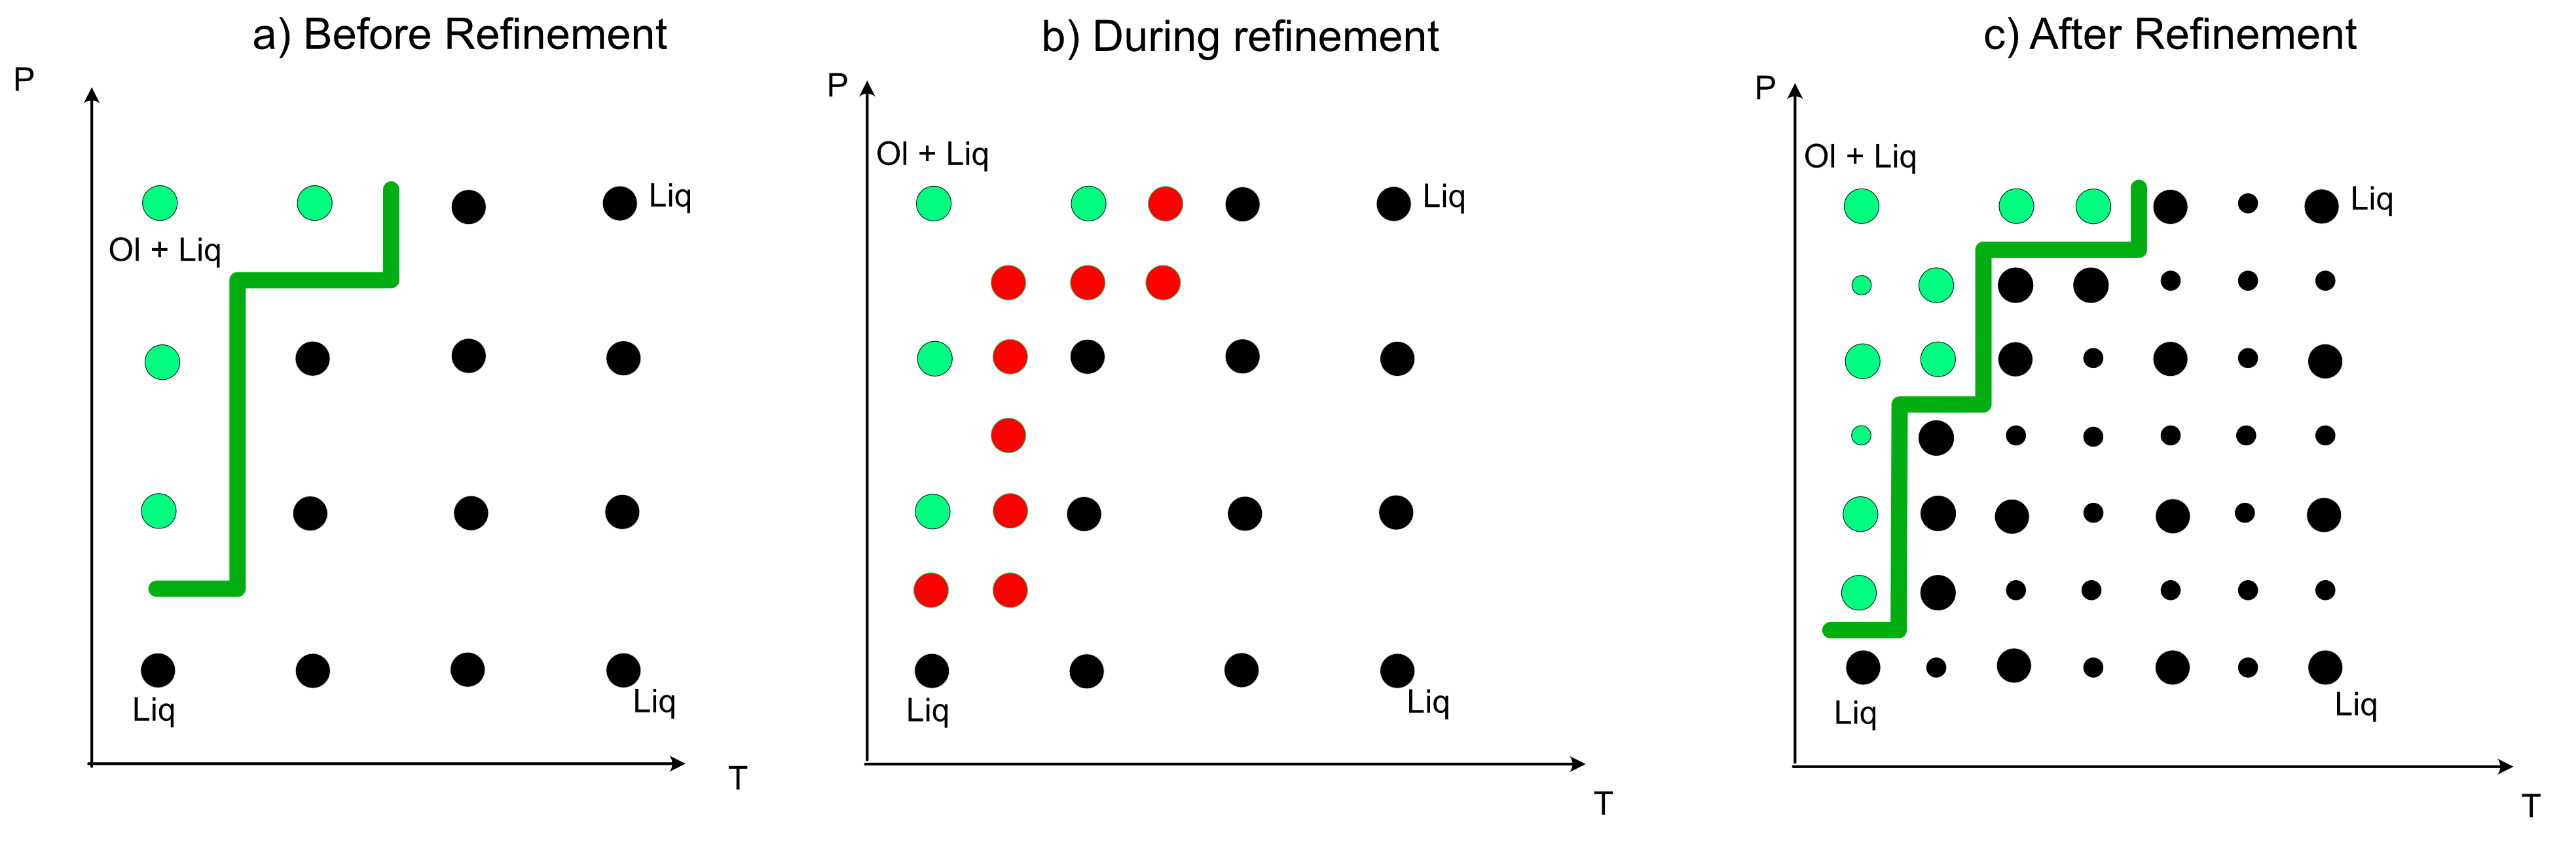
What the first refine step does is insert a new calculation anywhere two neighbouring points have a different phase assemble (the red dots). These are then solved, and the position of the phase boundary is obtained at a higher precision. To ensure that the matrix has a constant point spacing, new points are inserted between existing points with the same phase (e.g. the point between Ol - Ol is filled with olivine - in this diagram, these are the smaller circles in panel c). refine=2 would do this again after the first refinement stage. 

In [6]:
Res = ptt.phaseDiagram_calc(Model = "pMELTS", bulk = KLB1, 
                            P_bar = np.linspace(2000.0,40000.0, 25),
                            T_C = np.linspace(1200.0, 1800.0, 25),
                            i_max = 15, refine = 2)

In [7]:
Res

,T_C,P_bar,mass_g,H_J,S_J/K,V_cm^3,rho_kg/m^3,log10(fO2),dVdP_cm^3/bar,SiO2_Liq,...,H_J_Plag,S_J/K_Plag,Cp_J/(kg.K^2)_Plag,dCpdT_J/(kg.K^2)_Plag,dVdT_cm^3/K_Plag,dPdT_bar/K_Plag,d2VdT2_cm^3/K^2_Plag,d2VdTdP_cm^3/(bar.K)_Plag,d2VdP2_cm^3/bar^2_Plag,molwt_Plag
0,1200.0,2000.00,100.0,-1.290949e+06,248.341481,32.721230,3056.119810,-7.002093,0.001123,57.566112,...,-1669.685109,0.291509,1231.080407,0.000014,0.000001,NaN,3.584903e-10,0.0,3.027811e-13,275.838825
1,1200.0,2395.83,100.0,-1.292754e+06,246.250894,32.287001,3097.782011,-6.545452,0.001238,56.651383,...,-50221.326647,8.891283,1231.969856,0.000414,0.000032,NaN,1.061530e-08,0.0,9.707448e-12,274.939756
2,1200.0,2791.67,100.0,-1.294558e+06,244.160307,31.852772,3139.444212,-6.088810,0.001352,55.736654,...,-98772.968185,17.491058,1232.859305,0.000814,0.000064,NaN,2.087211e-08,0.0,1.911211e-11,274.040686
3,1200.0,3187.50,100.0,-1.294398e+06,243.415743,31.703106,3154.265053,-7.582875,0.001390,NaN,...,-112618.754551,20.023085,1233.255039,0.000923,0.000074,NaN,2.370736e-08,0.0,2.216741e-11,273.567139
4,1200.0,3583.33,100.0,-1.293231e+06,243.356628,31.676345,3156.929843,-7.606633,0.001390,NaN,...,-109311.858695,19.462473,1233.180084,0.000895,0.000072,NaN,2.301675e-08,0.0,2.159574e-11,273.489102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,1800.0,38416.67,100.0,-1.040325e+06,321.357506,32.587718,3068.640808,-3.661983,-0.000073,44.751355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9405,1800.0,38812.50,100.0,-1.039201e+06,321.278764,32.557331,3071.512900,-3.643697,-0.000073,44.758422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9406,1800.0,39208.33,100.0,-1.038077e+06,321.200022,32.526944,3074.384992,-3.625411,-0.000072,44.765489,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9407,1800.0,39604.17,100.0,-1.036952e+06,321.121280,32.496558,3077.257084,-3.607124,-0.000072,44.772555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The result is a DataFrame with 97 equally spaced temperature and pressure values (so total size of 97*97).
Why 97 you ask? Well initially its 25 in x and 25 in y. The refine then adds 24 points (one inbetween each point), so 49X49. The refine again adds another 48 points so (49+48) = 97 X 97.  For cases where the phase assemblage of 2 neighboring points was identical the phase proportions and phase chemistry is estimated through simply linear interpolation between the two neighbors. To view the phase diagram results we can use the `plot_phaseDiagram` function in `ptt`. This will create a phase diagram labelled by number, with each number corresponding to a phase assemblage listed on the right. By using `%matplotlib widget` above you should be able to hover over the plot and see which number (and therefore phase assemblage) is present at each P-T condition.

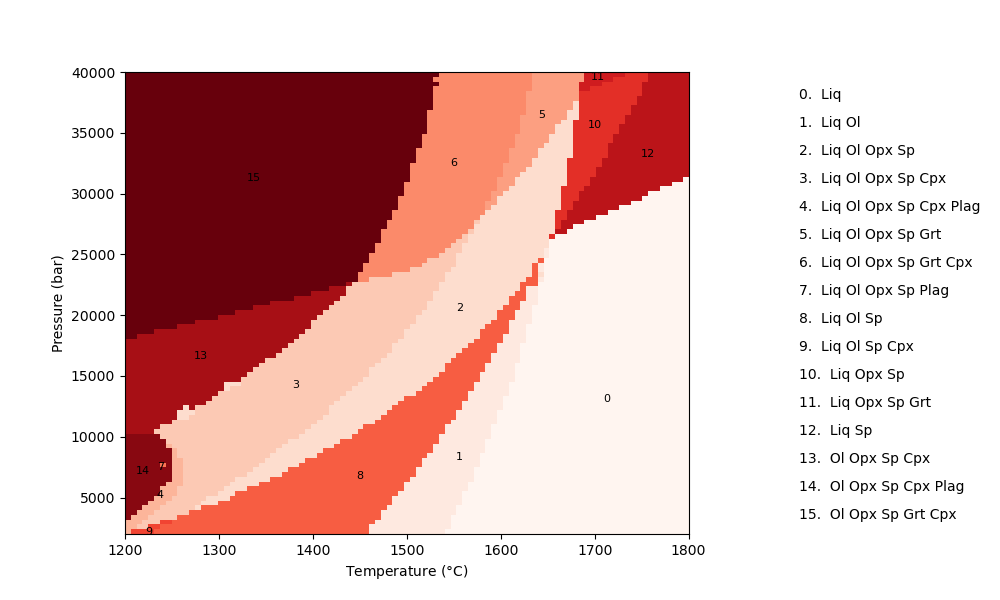

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: xlabel='Temperature ($\\degree$C)', ylabel='Pressure (bar)'>,
        <Axes: >], dtype=object))

In [8]:
ptt.plot_phaseDiagram(Combined = Res)

#### Calculations using MAGEMin

For calculations with MAGEMin it is important to note that this is one of the major purposes for which the original MAGEMin code was developed, so it will likely always be straightforward to create phase diagrams using the MAGEMinApp (https://github.com/ComputationalThermodynamics/MAGEMinApp.jl). The point of this code is not to try and replace MAGEMin, but to provide Python users with the ability to perform calcualtions with a range of different thermodynamic models.  In the cells below we repeat the calculations above with a few minor differences: (i) MAGEMin (and the Green et al. 2025 thermodynamic model) does not have the same issue as pMELTS when small amounts of K2O are included in the bulk composition; (ii) the `Model` kwarg is changed to `Green2025` which will initiate the calculation in julia via MAGEMin

In [9]:
KLB1 = ptt.Compositions['KLB-1']
KLB1

{'SiO2_Liq': 44.48,
 'TiO2_Liq': 0.16,
 'Al2O3_Liq': 3.59,
 'FeOt_Liq': 8.1,
 'MgO_Liq': 39.22,
 'CaO_Liq': 3.44,
 'Na2O_Liq': 0.3,
 'K2O_Liq': 0.0,
 'Cr2O3_Liq': 0.42,
 'H2O_Liq': 0.0,
 'Fe3Fet_Liq': 0.04}

In [10]:
Res_green = ptt.phaseDiagram_calc(Model = "Green2025", bulk = KLB1, 
                            P_bar = np.linspace(2000.0,40000.0, 25),
                            T_C = np.linspace(1200.0, 1800.0, 25),
                            Fe3Fet_init=0.0329,
                            i_max = 15, refine=2)

(<Figure size 1000x1000 with 3 Axes>,
 [<Axes: title={'center': 'Green'}, xlabel='Temperature ($\\degree$C)', ylabel='Pressure (bar)'>,
  <Axes: title={'center': 'pMELTS'}, xlabel='Temperature ($\\degree$C)', ylabel='Pressure (bar)'>,
  <Axes: >])

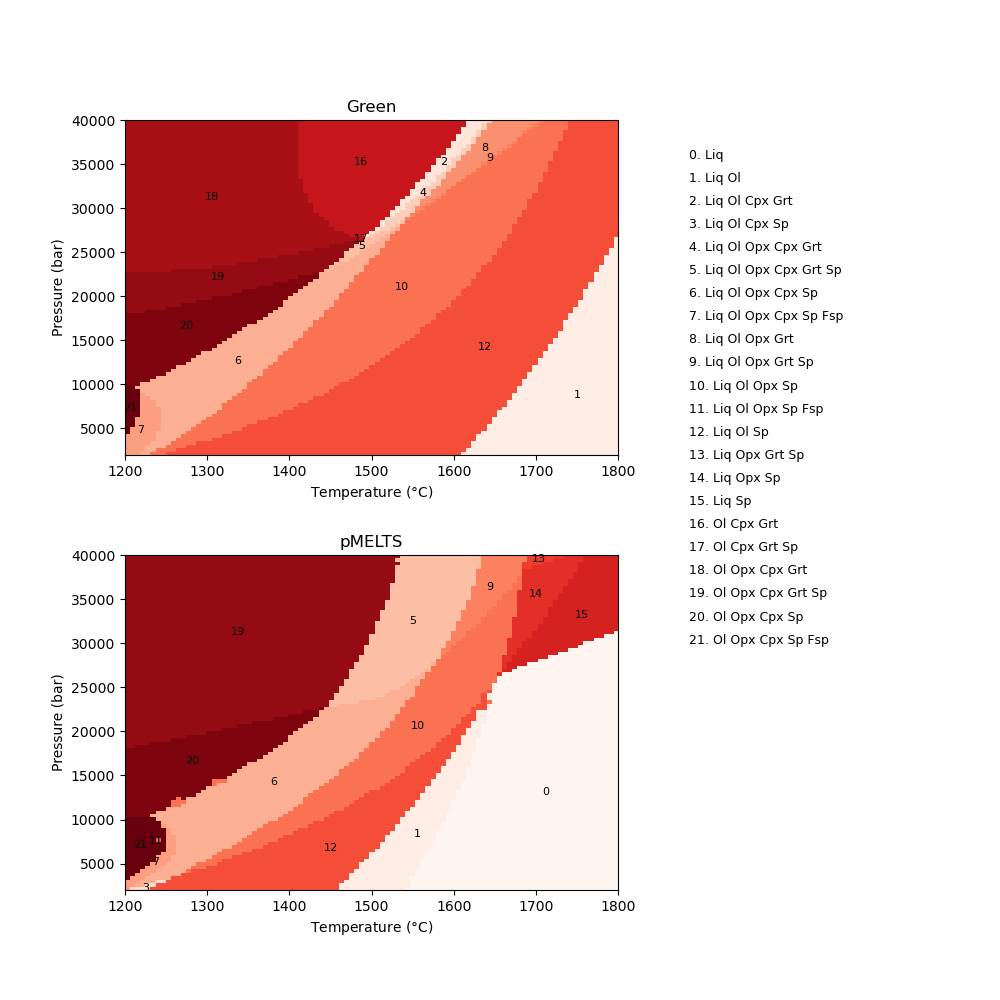

In [11]:
ptt.plot_phaseDiagram_multi({"Green": Res_green, "pMELTS": Res})

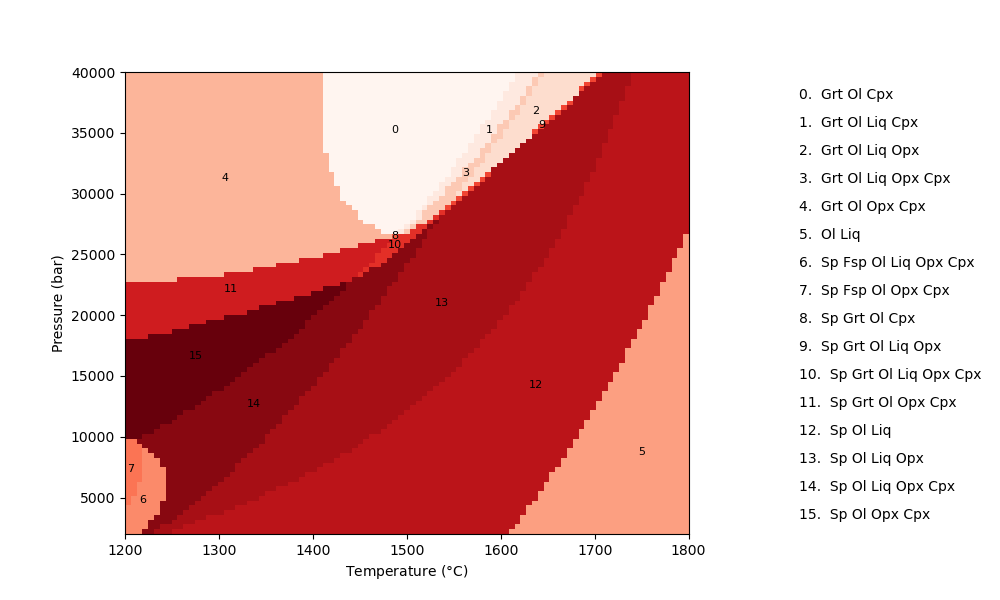

In [13]:
f, a = ptt.plot_phaseDiagram(Combined = Res_green)

In [14]:
Res_green

,T_C,P_bar,mass_g,H_J,S_J/K,V_cm^3,rho_kg/m^3,log10(fO2),mass_per_mole_g/mol,eta_Pa.s,...,TiO2_Opx,Al2O3_Opx,Cr2O3_Opx,FeOt_Opx,MgO_Opx,CaO_Opx,Na2O_Opx,K2O_Opx,H2O_Opx,Fe3Fet_Opx
0,1200.0,2000.00,100.0,-1.302116e+06,241.087797,31.907619,3134.047741,-7.704395,51.56407,139.416446,...,0.098416,3.798348,1.015754,6.593524,31.411665,2.550961,0.030869,0.0,0.0,0.128151
1,1200.0,2395.83,100.0,-1.301319e+06,240.774349,31.820360,3142.713260,-7.670190,51.56407,134.325704,...,0.115572,3.947066,0.989563,6.650103,31.372528,2.483727,0.035722,0.0,0.0,0.130600
2,1200.0,2791.67,100.0,-1.300523e+06,240.460901,31.733102,3151.378779,-7.635984,51.56407,129.234962,...,0.132728,4.095785,0.963372,6.706683,31.333391,2.416493,0.040576,0.0,0.0,0.133050
3,1200.0,3187.50,100.0,-1.299726e+06,240.147453,31.645844,3160.044298,-7.601779,51.56407,124.144220,...,0.149885,4.244504,0.937181,6.763262,31.294254,2.349259,0.045429,0.0,0.0,0.135500
4,1200.0,3583.33,100.0,-1.298929e+06,239.834005,31.558586,3168.709817,-7.567573,51.56407,119.053477,...,0.167041,4.393222,0.910990,6.819842,31.255117,2.282025,0.050283,0.0,0.0,0.137949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9404,1800.0,38416.67,100.0,-1.090848e+06,296.864626,32.489704,3077.898147,-3.015054,51.56407,0.045307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9405,1800.0,38812.50,100.0,-1.089783e+06,296.771597,32.470947,3079.679249,-2.997225,51.56407,0.045328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9406,1800.0,39208.33,100.0,-1.088719e+06,296.678568,32.452189,3081.460350,-2.979396,51.56407,0.045349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9407,1800.0,39604.17,100.0,-1.087654e+06,296.585539,32.433431,3083.241452,-2.961567,51.56407,0.045369,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Extracting more information from the phase diagram calculations

In addition to the phase diagrams shown above it is relatively simple to extract additional information from the calculations. For example, it is trivial to extract the mass of liquid (mass fraction) at each point and reshape this array into a P-T grid so that we can visualize this data as contours.

The function make_grid_variables_from_phase_diagram takes your dataframe output, and puts it into a PT grid. This allows for easier plotting. 

In [15]:
X, Y, Z = ptt.make_grid_variables_from_phase_diagram(
    Results = Res_green,
    x_col = "T_C",
    y_col = "P_bar",
)

liq = Z["mass_g_Liq"]


From here we can use the `plt.contourf` function to visualize the mass fraction of melt at each P-T value:

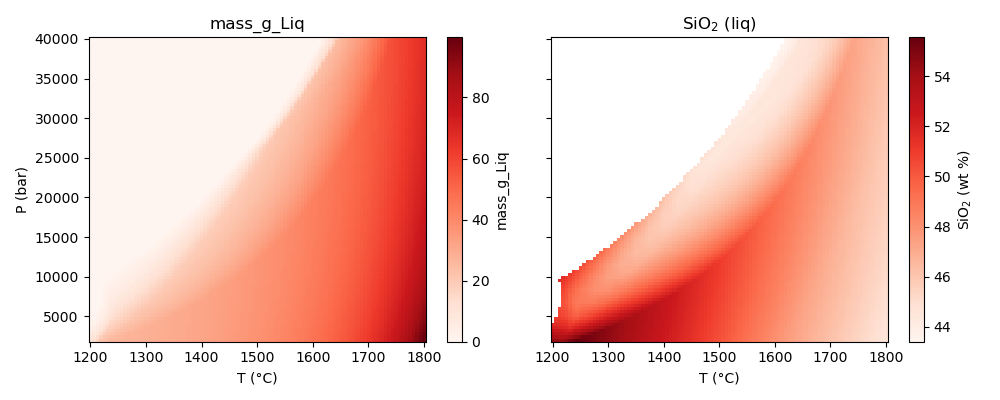

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 4), sharex=True, sharey=True
)

# ------------------------------------------------
# Panel 1: mass_g_Liq (red colormap)
# ------------------------------------------------
pcm1 = ax1.pcolormesh(
    X, Y, Z["mass_g_Liq"],
    shading="auto",
    cmap="Reds"
)
ax1.set_title("mass_g_Liq")
ax1.set_xlabel("T (°C)")
ax1.set_ylabel("P (bar)")
fig.colorbar(pcm1, ax=ax1, label="mass_g_Liq")

# ------------------------------------------------
# Panel 2: SiO2_Liq (same red colormap)
# ------------------------------------------------
pcm2 = ax2.pcolormesh(
    X, Y, Z["SiO2_Liq"],
    shading="auto",
    cmap="Reds"
)
ax2.set_title("SiO$_2$ (liq)")
ax2.set_xlabel("T (°C)")
fig.colorbar(pcm2, ax=ax2, label="SiO$_2$ (wt %)")

plt.tight_layout()
plt.show()


In [13]:
Res_green.columns

Index(['T_C', 'P_bar', 'mass_g', 'h_J', 's_J/K', 'v_cm3', 'rho_kg/m3',
       'log10(fO2)', 'mass_per_mole_g/mol', 'eta_Pa.s',
       ...
       'mass_g_Cpx2', 'rho_kg/m3_Cpx2', 'v_cm3_Cpx2', 'h_J_Cpx2', 's_J/K_Cpx2',
       'cp_J/kg/K_Cpx2', 'mass%_Cpx2', 'mol%_Cpx2', 'vol%_Cpx2',
       'alpha_1/K_Cpx2'],
      dtype='object', length=181)

Alternatively we could assess the proportion of garnet and spinel in the system, examining the position of the garnet-spinel transition.

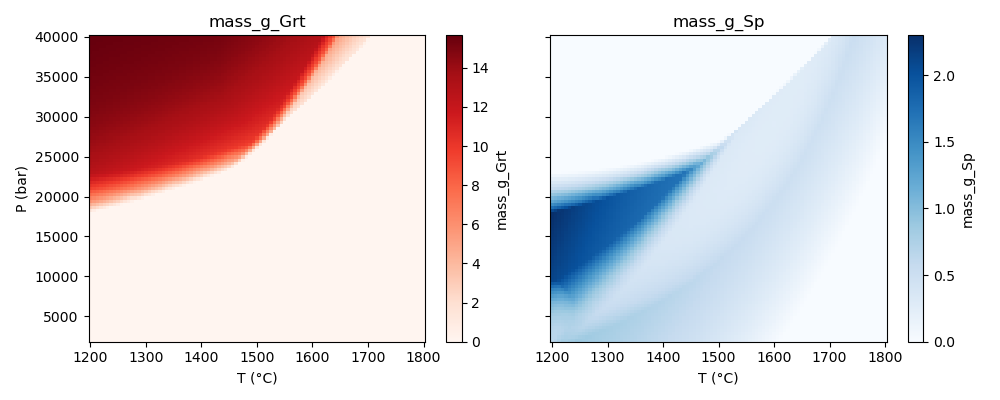

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 4), sharex=True, sharey=True
)

# ------------------------------------------------
# Panel 1: mass_g_Grt (red colormap)
# ------------------------------------------------
pcm1 = ax1.pcolormesh(
    X, Y, Z['mass_g_Grt'],
    shading="auto",
    cmap="Reds"
)
ax1.set_title("mass_g_Grt")
ax1.set_xlabel("T (°C)")
ax1.set_ylabel("P (bar)")
fig.colorbar(pcm1, ax=ax1, label="mass_g_Grt")

# ------------------------------------------------
# Panel 2: mass_g_Sp (blue colormap)
# ------------------------------------------------
pcm2 = ax2.pcolormesh(
    X, Y, Z['mass_g_Sp'],
    shading="auto",
    cmap="Blues"
)
ax2.set_title("mass_g_Sp")
ax2.set_xlabel("T (°C)")
fig.colorbar(pcm2, ax=ax2, label="mass_g_Sp")

plt.tight_layout()
plt.show()


#### Phase Diagram of pyroxenite lithologies

Alternatively we could create phase diagram for other, potential mantle lithologies. Shown as an example here is a phase diagram calculation for the KG1 pyroxenite.

In [15]:
KG1 = ptt.Compositions['KG1']

In [16]:
KG1_green = ptt.phaseDiagram_calc(Model = "Green2025", bulk = KG1, 
                            P_bar = np.linspace(2000.0,40000.0, 25),
                            T_C = np.linspace(1200.0, 1800.0, 25),
                            i_max = 15, refine = 2)

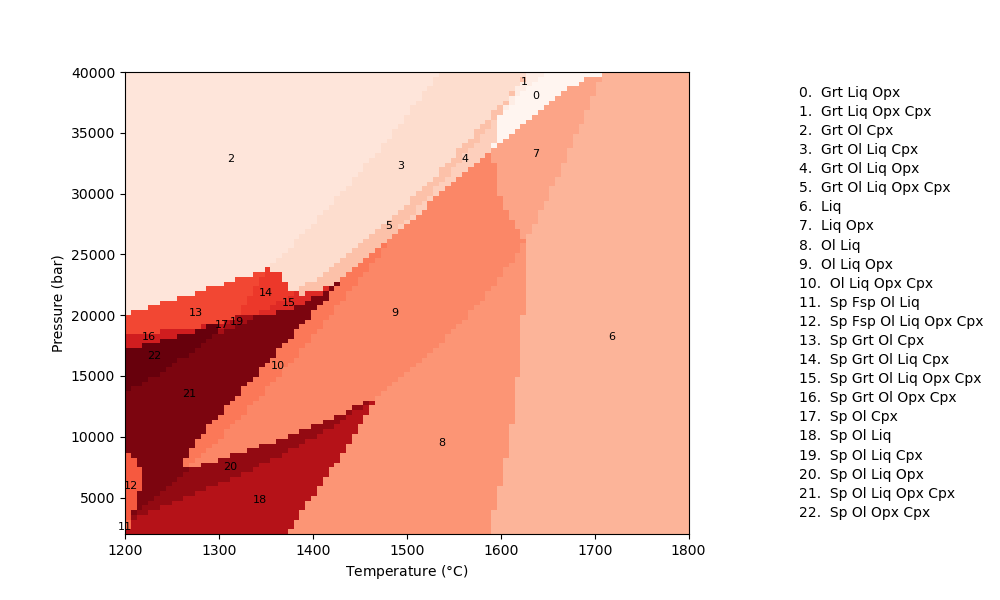

In [17]:
f, a = ptt.plot_phaseDiagram(Combined = KG1_green)